# Credit Scoring Model 
# Dataset: Lending Club Loan Data 

In [ ]:
## importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


### Load Dataset

In [3]:
file_path = 'accepted_2007_to_2018Q4.csv/accepted_2007_to_2018Q4.csv'
df = pd.read_csv(file_path, low_memory=False)
print("Original shape:", df.shape)

Original shape: (2260701, 151)


### Filter target labels

In [4]:
valid_status = ["Fully Paid", "Charged Off"]
df = df[df['loan_status'].isin(valid_status)]
df['target'] = df['loan_status'].map({'Fully Paid':1, 'Charged Off':0})
print("Filtered shape:", df.shape)

Filtered shape: (1345310, 152)


### Feature Selection

In [5]:
selected_features = [
    'loan_amnt','term','int_rate','installment','annual_inc','emp_length',
    'home_ownership','purpose','dti','open_acc','revol_bal','revol_util','total_acc'
]
df = df[selected_features + ['target']].copy()

In [6]:
# Handle missing values simply
df = df.dropna(subset=['loan_amnt','int_rate','annual_inc','dti'])

### Feature Engineering

In [7]:
df['income_to_loan_ratio'] = df['annual_inc'] / (df['loan_amnt'] + 1e-6)
df['installment_to_income_ratio'] = df['installment'] / (df['annual_inc'] + 1e-6)

In [8]:
def emp_length_to_num(x):
    try:
        if pd.isnull(x):
            return np.nan
        if str(x).strip() == '< 1 year':
            return 0.5
        if str(x).strip() == '10+ years':
            return 10
        return float(str(x).split()[0])
    except:
        return np.nan

df['emp_length_num'] = df['emp_length'].apply(emp_length_to_num)
df = df.drop(columns=['emp_length'])

In [9]:
final_features = [
    'loan_amnt','term','int_rate','installment','annual_inc',
    'home_ownership','purpose','dti','open_acc','revol_bal','revol_util','total_acc',
    'income_to_loan_ratio','installment_to_income_ratio','emp_length_num'
    ]

### Train/Test Split

In [10]:
X = df[final_features]
y = df['target']

categorical_cols = ['term','home_ownership','purpose']
numeric_cols = [col for col in final_features if col not in categorical_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Preprocessing Pipeline

In [11]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Model Pipeline

In [12]:

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

### Model Training

In [13]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'dti', 'open_acc',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc',
                                                   'income_to_loan_ratio',
                                                   'installment_to_income_ratio',
                                                   'emp_length_num']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'home_ownership',
                                                   'purpose'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Model Evalution

In [14]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.50      0.09      0.15     53698
           1       0.81      0.98      0.89    215290

    accuracy                           0.80    268988
   macro avg       0.66      0.53      0.52    268988
weighted avg       0.75      0.80      0.74    268988

ROC-AUC: 0.693555813224435


### Confusion matrix

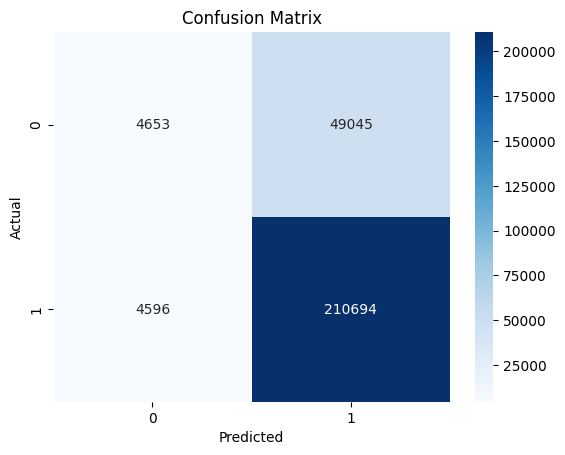

In [15]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()